# Trump Tweets

This the data behind the story [The World’s Favorite Donald Trump Tweets](https://fivethirtyeight.com/features/the-worlds-favorite-donald-trump-tweets/).

In [2]:
# The usual suspects ...
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
import string
import re
import pyLDAvis.gensim
import pandas_profiling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time_series as ts

# And their accomplices ...
from scipy import stats
from matplotlib.ticker import FuncFormatter
from textblob import TextBlob
from gensim import corpora
from gensim import models
from gensim import similarities
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from collections import Counter
from pprint import pprint

# Settings
sns.set_style('white')
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# Getting the data
df = pd.read_csv('data/realDonaldTrump_poll_tweets.csv')

In [4]:
# Size
df.shape

(448, 3)

In [5]:
# Top rows
df.head()

,id,created_at,text
0,7.656299e+17,8/16/2016 19:22:57,"It's just a 2-point race, Clinton 38%, Trump 3..."
1,7.587319e+17,7/28/2016 18:32:31,"""@LallyRay: Poll: Donald Trump Sees 17-Point P..."
2,7.583505e+17,7/27/2016 17:16:56,Great new poll - thank you!\n#MakeAmericaGreat...
3,7.575775e+17,7/25/2016 14:05:27,Great POLL numbers are coming out all over. Pe...
4,7.536034e+17,7/14/2016 14:53:46,Another new poll. Thank you for your support! ...


#### Preprocessing

In [6]:
# Datetime
ts.convert_to_datetime(data=df, column='created_at')

In [7]:
# Removing @user references and links
def strip_links(text):
    '''Removes links in text.'''
    link_regex = re.compile(r'((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text

def strip_all_entities(text):
    '''Removes @user references and hashtags.'''
    entity_prefixes = ['@', '#']
    for separator in string.punctuation:
        if separator not in entity_prefixes:
            text = text.replace(separator, ' ')
    words = list()
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
for i in range(len(df)):
    df.loc[i, 'text'] = strip_all_entities(strip_links(df.loc[i, 'text']))

df['text'].head(10)

0         It s just a 2 point race Clinton 38 Trump 36
1    Poll Donald Trump Sees 17 Point Positive Swing...
2                             Great new poll thank you
3    Great POLL numbers are coming out all over Peo...
4    Another new poll Thank you for your support Jo...
5                     Great new poll thank you America
6    Despite spending 500k a day on TV ads alone fa...
7                         Great poll Florida Thank you
8                                   New poll thank you
9    New Q poll out we are going to win the whole d...
Name: text, dtype: object

In [9]:
# Text corpus
def create_document_corpus(df, column):
    '''Creates document corpus.'''
    return [i for i in df[column]]

# Removing common words and tokenize
def remove_common_words_and_tokenize(document_corpus):
    '''Removes common words and tokenizes text.'''
    stop_words = set(stopwords.words('english'))
    stop_words.update(['-', '=', '+', '*','.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']',
                       '{', '}', 'amp', 'kkk', 'hahaha', 'haha', 'ha', 'RT', 'i’m', '…', '–', 'http'])
    stop_words.update([i for i in string.ascii_lowercase]) # Including lowercase letters
    stop_words.update([i for i in string.ascii_uppercase]) # Including uppercase letters
    for doc in document_corpus:
        list_of_words = [i.lower() for i in wordpunct_tokenize(doc) if i.lower() not in stop_words]
    stop_words.update(list_of_words)

    # Removing common words
    return [[word for word in doc.lower().split() if word not in stop_words] for doc in document_corpus]

# Removing words that appear only once
def remove_words_appearing_only_once(text_corpus):
    '''Removes words that appear only once.'''
    frequency = defaultdict(int)
    for text in text_corpus:
        for token in text:
            frequency[token] += 1

    return [[token for token in text if frequency[token] > 1] for text in text_corpus]

# Removing emojis
def remove_emojis(text_corpus):
    '''Removes emojis and emoticons from text corpus.'''
    # Emoticons and emojis
    # HappyEmoticons
    emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
                           ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
                           '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
                           'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
                           '<3'])

    # Sad Emoticons
    emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
                         ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
                         ':c', ':{', '>:\\', ';('])

    # Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)

    # Combine
    emoticons = emoticons_happy.union(emoticons_sad)
    return [[token for token in text if token not in emoticons] for text in text_corpus]

# Removing empty tokens
def remove_empty_corpus_tokens(text_corpus):
    '''Removes empty text corpus tokens.'''
    return [text for text in text_corpus if len(text) > 1]

In [10]:
# Formatting
document = create_document_corpus(df, 'text')
text_corpus = remove_common_words_and_tokenize(document)
refined_text_corpus = remove_words_appearing_only_once(text_corpus)
no_emojis_refined_text_corpus = remove_emojis(refined_text_corpus)
no_empty_tokens_refined_text_corpus = remove_empty_corpus_tokens(no_emojis_refined_text_corpus)

# Printing the top 10
pprint(no_empty_tokens_refined_text_corpus[:10])

[['2', 'point', 'race', 'clinton', '38', 'trump', '36'],
 ['poll', 'donald', 'trump', '17', 'point', 'two', 'breitbart', 'great'],
 ['great', 'new', 'poll', 'thank'],
 ['great',
  'poll',
  'numbers',
  'coming',
  'people',
  'want',
  'another',
  'four',
  'years',
  'obama',
  'crooked',
  'hillary',
  'even',
  'worse'],
 ['another', 'new', 'poll', 'thank', 'support'],
 ['great', 'new', 'poll', 'thank', 'america'],
 ['despite', 'spending', 'day', 'ads', 'nationwide', 'zero', 'sad'],
 ['great', 'poll', 'florida', 'thank'],
 ['new', 'poll', 'thank'],
 ['new', 'poll', 'going', 'win', 'make', 'america', 'great']]


#### Transformation: Document dictionary

In [11]:
# Create dictionary of document
bag = corpora.Dictionary(no_empty_tokens_refined_text_corpus)
bag.save('models/trump.dict')

# Converting document to a vector (bag-of-words)
corpus = [bag.doc2bow(text) for text in no_empty_tokens_refined_text_corpus]
corpora.MmCorpus.serialize('models/trump.mm', corpus)

We have assigned a unique integer id to all words appearing in the corpus by:
   
   1. sweeping across the texts
   2. collecting word counts and relevant statistics

***

#### Transformation: _tf-idf_

#### Step 1:

We have initialized (trained) a transaformation model. Different transformation may require different initialization parameters; however, in our case, ___tf-idf___, the "training" consists simply of going through the supplied corpus once and computing document frequencies of all its features. This is in comparison to ___Latent Semantic Analysis___ & ___Latent Dirichlet Allocation___ which are more involved and take more time.

**A note on transaformations**:
Transformations always convert between two specific vector spaces. The same vector space (= the same set of feature ids) must be used for training as well as for subsequent vector transformations. Failure to use the same input feature space, such as applying a different string preprocessing, using different feature ids, or using bag-of-words input vectors where ___tf-idf___ vectors are expceted, will result in feature mismatch during transformation calls and consequently in either garbage output and/or runtime exceptions.

#### Step 2:
From now on, ___tf-idf___ is treated as a read-only object that can be used to convert any vector from the old representation (___bag-of-words___ integer counts) to the new representation (___tf-idf___ real-valued weights).

We have transformed our corpus (the one we used for training) into a weighted vector. We can do this for any vector (provided they come from the same vector space), even if they are not used in the corpus at all. This can be achived by _folding-in_ for ___LSA___ and by _topic inference_ for ___LDA___.

#### Step 3:
We will transform our ___tf-idf___ corpus via [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing) into a latent 10-D space (... num_topics = 10).

In [12]:
# Initializing tf-idf
def create_tfidf_model(corpus):
    '''Transform text to tf-idf model.'''
    # Initialization
    tfidf = models.TfidfModel(corpus)
    # Applying the transformation to the whole corpus
    return tfidf, tfidf[corpus]

tfidf, corpus_tfidf = create_tfidf_model(corpus)

In [13]:
# Initializing an LSI transformation
def create_lsi_model(corpus_tfidf, id2word=bag, num_topics=5):
    '''Initializes an LSI transformation of tf-idf model.'''
    lsi = models.LsiModel(corpus_tfidf, id2word=bag, num_topics=5)
    # Model persistence: save(), load()
    lsi.save('models/trump.lsi')
    lsi = models.LsiModel.load('models/trump.lsi')
    return lsi, lsi[corpus_tfidf]

lsi, corpus_lsi = create_lsi_model(corpus_tfidf)

In [14]:
lsi.print_topics()

[(0,
  '0.546*"thank" + 0.413*"new" + 0.385*"great" + 0.202*"poll" + 0.165*"america" + 0.150*"numbers" + 0.144*"iowa" + 0.120*"reuters" + 0.118*"trump" + 0.108*"big"'),
 (1,
  '-0.457*"thank" + 0.311*"trump" + 0.187*"lead" + 0.187*"donald" + 0.185*"carson" + 0.177*"rubio" + -0.176*"great" + 0.168*"cruz" + 0.166*"leads" + 0.162*"6"'),
 (2,
  '0.274*"debate" + -0.215*"6" + -0.213*"carson" + -0.189*"thank" + 0.186*"big" + 0.181*"great" + -0.179*"rubio" + 0.179*"every" + 0.177*"america" + 0.176*"said"'),
 (3,
  '0.418*"great" + -0.374*"debate" + 0.287*"big" + 0.262*"leads" + -0.194*"iowa" + -0.189*"thank" + -0.186*"said" + -0.184*"national" + -0.159*"post" + -0.156*"lead"'),
 (4,
  '0.369*"debate" + -0.331*"national" + -0.315*"iowa" + -0.204*"new" + 0.184*"said" + 0.167*"carson" + 0.163*"great" + -0.154*"lead" + 0.153*"thank" + 0.146*"rubio"')]

#### Topics

According to ___LSI___:
<br>
**Topic 1**
> References poll numbers, Iowa, Reuters and Trump.

**Topic 2**
> References Trump, Carson, Rubio, and Cruz. This may Trump making comparisons with his competition.

**Topic 3**
> References debate, Carson, and Rubio hinting at what these individuals may have said in the debate.

**Topic 4**
> References great, debate, big, and leads. This may be Trump talking about the debate and the favorable outcome.

**Topic 5**
> References similar words as topic 4.

***
### Similarity

In [15]:
def query_similarity(doc, lsi_model=lsi, dict_of_doc=bag, doc_corpus=document):
    # Initializing the query structure: transform corpus to LSI space and index it
    index = similarities.MatrixSimilarity(lsi_model[corpus])

    # Index persistence
    index.save('models/trump.index')
    index = similarities.MatrixSimilarity.load('models/trump.index')
    
    # Performing queries
    vec_bow = dict_of_doc.doc2bow(doc.lower().split())

    # Convert the query to LSI space
    vec_lsi = lsi_model[vec_bow]

    # Perform a similarity query against the corpus
    sims = index[vec_lsi]

    # Ranking the tweets by their weights of similarity
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    # Printing the associated Tweets:
    for i in range(10):
        print("Tweet Rank #{}:\tWeight: {}\nRaw text: {}\n".format(i+1, sims[i][1], doc_corpus[sims[i][0]]))

query_similarity(doc='Hillary Clinton')

Tweet Rank #1:	Weight: 0.9824669361114502
Raw text: Hillary Clinton is not a change agent just the same old status quo She is spending a fortune I am spending very little Close in polls

Tweet Rank #2:	Weight: 0.9604358673095703
Raw text: New CBS National Poll just out massive lead for Trump The Wall Street Journal NBC Poll is a total joke No wonder WSJ is doing so badly

Tweet Rank #3:	Weight: 0.9455323219299316
Raw text: CNBC poll Trump won

Tweet Rank #4:	Weight: 0.9381183981895447
Raw text: Don t believe the Polls they are just another phony hit job on me I will beat Hillary Clinton easily in the General Election

Tweet Rank #5:	Weight: 0.9191676378250122
Raw text: Polling Convergence OAN GRAVIS and Reuters Show Donald Trump Surging With 34 35 Support via

Tweet Rank #6:	Weight: 0.9182190895080566
Raw text: Ted Cruz didn t win Iowa he stole it That is why all of the polls were so wrong and why he got far more votes than anticipated Bad

Tweet Rank #7:	Weight: 0.9146757125854492
Raw

When we make a query for "Hillary Clinton" to retrieve the respective top tweets associated with her name, we find that the leading tweet with the greatest weight is a strong criticism of Hillary Clinton and her campaign spending. The remaining nine tweets are associated with the polls, darted with references to Donald Trump criticizing poll results not in his favor, him leading against the opposition as well as pitting himself likely to win.

In [16]:
# Performing queries
query_similarity(doc="Carson")

Tweet Rank #1:	Weight: 0.9985800981521606
Raw text: All seven on line polls including Drudge and Time with thousands of respondents said I won the debate said I was so so

Tweet Rank #2:	Weight: 0.9964035153388977
Raw text: New CNN ORC poll w 24 favorability rating on the rise while Jeb s declines 60 among women

Tweet Rank #3:	Weight: 0.9904822111129761
Raw text: WSJ NBC Poll Donald Trump Widens His Lead in Republican Presidential Race

Tweet Rank #4:	Weight: 0.9878135323524475
Raw text: Good morning America Thank you for all of your support in the latest Drudge poll

Tweet Rank #5:	Weight: 0.9766283631324768
Raw text: Michigan GOP poll 2 24 2016 Trump 35 5 Rubio 15 0 Cruz 14 3 Kasich 12 8 Carson 8 3 Wow

Tweet Rank #6:	Weight: 0.9751218557357788
Raw text: Heading to a packed house in Waterloo Iowa Will celebrate today s great poll numbers together See you soon

Tweet Rank #7:	Weight: 0.9703835248947144
Raw text: Rasmussen now beats 38 36 nationally

Tweet Rank #8:	Weight: 0.962513387

#### Transformation: LDA

In [17]:
# Initialize an LDA transformation
def create_lda_model(corpus_tfidf, idf2word=bag, num_topics=5):
    '''Initializes LDA transformation.'''
    # LDA Transformation
    lda = models.LdaModel(corpus_tfidf, id2word=bag, num_topics=5)
    return lda, lda[corpus_tfidf]
    
lda, corpus_lda = create_lda_model(corpus_tfidf)

In [18]:
lda.print_topics()

[(0,
  '0.021*"thank" + 0.017*"new" + 0.015*"great" + 0.012*"trump" + 0.011*"poll" + 0.009*"cnn" + 0.009*"post" + 0.008*"america" + 0.008*"carson" + 0.008*"win"'),
 (1,
  '0.021*"thank" + 0.017*"new" + 0.013*"great" + 0.010*"poll" + 0.010*"reuters" + 0.009*"6" + 0.009*"iowa" + 0.009*"numbers" + 0.009*"news" + 0.007*"trump"'),
 (2,
  '0.011*"trump" + 0.011*"new" + 0.011*"big" + 0.010*"iowa" + 0.010*"lead" + 0.010*"leading" + 0.010*"great" + 0.008*"poll" + 0.007*"9" + 0.007*"win"'),
 (3,
  '0.012*"national" + 0.011*"leads" + 0.011*"new" + 0.010*"trump" + 0.010*"said" + 0.008*"poll" + 0.008*"even" + 0.007*"lead" + 0.007*"place" + 0.007*"quinnipiac"'),
 (4,
  '0.011*"great" + 0.010*"trump" + 0.010*"thank" + 0.009*"big" + 0.009*"debate" + 0.009*"rubio" + 0.009*"new" + 0.008*"10" + 0.008*"poll" + 0.007*"wow"')]

In [19]:
# Visualizing LDA topic models
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.013075  0.064550       1        1  25.959011
0     -0.050037 -0.023663       2        1  20.107786
1     -0.012086 -0.012458       3        1  19.667921
3      0.066788 -0.031741       4        1  17.234274
4     -0.017739  0.003311       5        1  17.031010, topic_info=    Category       Freq        Term      Total  loglift  logprob
14   Default  46.000000       thank  46.000000  30.0000  30.0000
155  Default  12.000000        said  12.000000  29.0000  29.0000
336  Default   7.000000  quinnipiac   7.000000  28.0000  28.0000
267  Default   9.000000       ahead   9.000000  27.0000  27.0000
66   Default  19.000000       leads  19.000000  26.0000  26.0000
39   Default  15.000000         win  15.000000  25.0000  25.0000
206  Default   7.000000       south   7.000000  24.0000  24.0000
180  Default   7.000000    carolina   7.000000  23.0000  23.0000
179  Default   5.000000          18   5.000000  22.0000  22.0000
299  Default   7.000000      highly   7.000000  21.0000  21.0000
467  Default   7.000000     percent   7.000000  20.0000  20.0000
519  Default   6.000000     newsmax   6.000000  19.0000  19.0000
184  Default  13.000000           6  13.000000  18.0000  18.0000
250  Default  13.000000        post  13.000000  17.0000  17.0000
76   Default   9.000000        like   9.000000  16.0000  16.0000
108  Default  16.000000     reuters  16.000000  15.0000  15.0000
286  Default   9.000000       zogby   9.000000  14.0000  14.0000
301  Default   7.000000          39   7.000000  13.0000  13.0000
300  Default   7.000000   respected   7.000000  12.0000  12.0000
109  Default   9.000000         yet   9.000000  11.0000  11.0000
18   Default  13.000000        even  13.000000  10.0000  10.0000
222  Default   6.000000        went   6.000000   9.0000   9.0000
2    Default   7.000000          38   7.000000   8.0000   8.0000
429  Default   5.000000       video   5.000000   7.0000   7.0000
201  Default  22.000000    national  22.000000   6.0000   6.0000
297  Default   9.000000       place   9.000000   5.0000   5.0000
344  Default   7.000000       stage   7.000000   4.0000   4.0000
129  Default   9.000000           1   9.000000   3.0000   3.0000
240  Default   5.000000          nh   5.000000   2.0000   2.0000
252  Default   5.000000        says   5.000000   1.0000   1.0000
..       ...        ...         ...        ...      ...      ...
347   Topic5   1.841775       front   4.531900   0.8697  -5.8529
348   Topic5   1.838071      runner   4.533072   0.8675  -5.8549
22    Topic5   1.777680       obama   4.410258   0.8615  -5.8883
362   Topic5   2.191907   including   5.507047   0.8489  -5.6789
459   Topic5   2.175285          22   5.502052   0.8422  -5.6865
356   Topic5   2.738876   announced   7.103146   0.8171  -5.4561
267   Topic5   3.561595       ahead   9.393245   0.8004  -5.1934
139   Topic5   5.620641       rubio  16.334398   0.7033  -4.7372
178   Topic5   5.337185          10  15.506083   0.7036  -4.7889
284   Topic5   2.715897    received   7.248105   0.7885  -5.4645
90    Topic5   3.391473  republican  10.026777   0.6861  -5.2424
111   Topic5   5.965235         big  24.527958   0.3563  -4.6777
42    Topic5   4.308209        good  15.148278   0.5128  -5.0031
86    Topic5   4.596200         wow  16.913952   0.4672  -4.9384
151   Topic5   5.758966      debate  25.442053   0.2845  -4.7129
61    Topic5   4.341697       shows  15.919056   0.4709  -4.9954
10    Topic5   7.109618       great  40.951218   0.0192  -4.5022
6     Topic5   6.504558       trump  38.413155  -0.0058  -4.5911
18    Topic5   3.725455        even  13.674719   0.4698  -5.1484
83    Topic5   4.495604        cruz  20.608551   0.2475  -4.9605
14    Topic5   6.311121       thank  46.037682  -0.2170  -4.6213
165   Topic5   3.835377        bush  15.296839   0.3868  -5.1194
11    Topic5   5.098953        poll  34.869720  -0.1524  -4.8346
13  

#### Dominant topics and percentage contribution

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=no_empty_tokens_refined_text_corpus):
    '''Returns dominant topics and respective percentage contributions with original text.'''
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_distribution', 'topic_keywords']
    
    # Add original text to the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sent_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=no_empty_tokens_refined_text_corpus)

In [21]:
# Formatting
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
df_dominant_topic.head(10)

,document_number,dominant_topic,topic_percentage_contribution,keywords,text
0,0,0.0,0.8980,"thank, new, great, trump, poll, cnn, post, ame...","[2, point, race, clinton, 38, trump, 36]"
1,1,2.0,0.9087,"trump, new, big, iowa, lead, leading, great, p...","[poll, donald, trump, 17, point, two, breitbar..."
2,2,0.0,0.8371,"thank, new, great, trump, poll, cnn, post, ame...","[great, new, poll, thank]"
3,3,1.0,0.9454,"thank, new, great, poll, reuters, 6, iowa, num...","[great, poll, numbers, coming, people, want, a..."
4,4,1.0,0.8644,"thank, new, great, poll, reuters, 6, iowa, num...","[another, new, poll, thank, support]"
5,5,0.0,0.8645,"thank, new, great, trump, poll, cnn, post, ame...","[great, new, poll, thank, america]"
6,6,3.0,0.8980,"national, leads, new, trump, said, poll, even,...","[despite, spending, day, ads, nationwide, zero..."
7,7,0.0,0.8369,"thank, new, great, trump, poll, cnn, post, ame...","[great, poll, florida, thank]"
8,8,0.0,0.7961,"thank, new, great, trump, poll, cnn, post, ame...","[new, poll, thank]"
9,9,0.0,0.8986,"thank, new, great, trump, poll, cnn, post, ame...","[new, poll, going, win, make, america, great]"


#### Most representative sentence for each topic

In [22]:
# Formatting
sent_topic_sorted_df_mallet = pd.DataFrame()
sent_topic_out_df_grouped = df_topic_sent_keywords.groupby('dominant_topic')

for item, group in sent_topic_out_df_grouped:
    sent_topic_sorted_df_mallet = pd.concat([sent_topic_sorted_df_mallet,
                                             group.sort_values(['percentage_distribution'],
                                                               ascending=False).head(1)],
                                            axis=0)
    
# Reset index
sent_topic_sorted_df_mallet.reset_index(drop=True, inplace=True)

# Formatting
sent_topic_sorted_df_mallet.columns = ['topic_number', 'topic_percentage_contribution', 'keywords', 'representative_text']

# Display
sent_topic_sorted_df_mallet.head(10)

,topic_number,topic_percentage_contribution,keywords,representative_text
0,0.0,0.9657,"thank, new, great, trump, poll, cnn, post, ame...","[poll, wow, new, hampshire, trump, 38, carson,..."
1,1.0,0.9611,"thank, new, great, poll, reuters, 6, iowa, num...","[report, reuters, 5, day, rolling, poll, trump..."
2,2.0,0.9515,"trump, new, big, iowa, lead, leading, great, p...","[new, cnn, iowa, poll, trump, 33, cruz, 20, ev..."
3,3.0,0.9545,"national, leads, new, trump, said, poll, even,...","[new, cbs, national, poll, massive, lead, trum..."
4,4.0,0.9568,"great, trump, thank, big, debate, rubio, new, ...","[great, poll, thank, north, carolina, 3, 15, t..."


#### Frequency distribution of word counts in documents

Text(0.5, 1.0, 'Distribution of Document Word Counts')

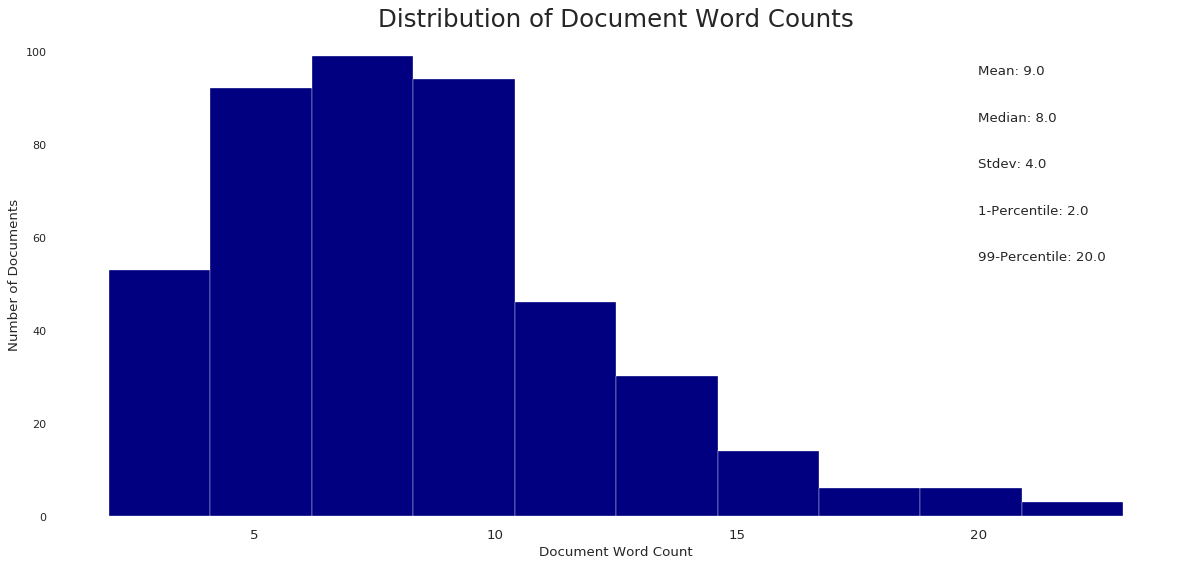

In [23]:
# Document length
doc_length = [len(d) for d in df_dominant_topic['text']]

# Plotting
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(doc_length, bins=10, color='navy')
plt.text(20, 95, 'Mean: ' + str(round(np.mean(doc_length))), fontsize=12)
plt.text(20, 85, 'Median: ' + str(round(np.median(doc_length))), fontsize=12)
plt.text(20, 75, 'Stdev: ' + str(round(np.std(doc_length))), fontsize=12)
plt.text(20, 65, '1-Percentile: ' + str(round(np.quantile(doc_length, q=0.01))), fontsize=12)
plt.text(20, 55, '99-Percentile: ' + str(round(np.quantile(doc_length, q=0.99))), fontsize=12)
plt.xticks(size=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xlabel('Document Word Count', fontsize=12)
plt.title('Distribution of Document Word Counts', fontsize=22)

#### Word counts of topic keywords

In [24]:
# Formatting
def word_counts_of_topic_keywords(lda_model, text_corpus):
    '''Returns the word counts of topic keywords.'''
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in text_corpus for w in w_list]
    counter = Counter(data_flat)

    out = list()
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, counter[word]])
    return pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

data = word_counts_of_topic_keywords(lda, no_empty_tokens_refined_text_corpus)

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

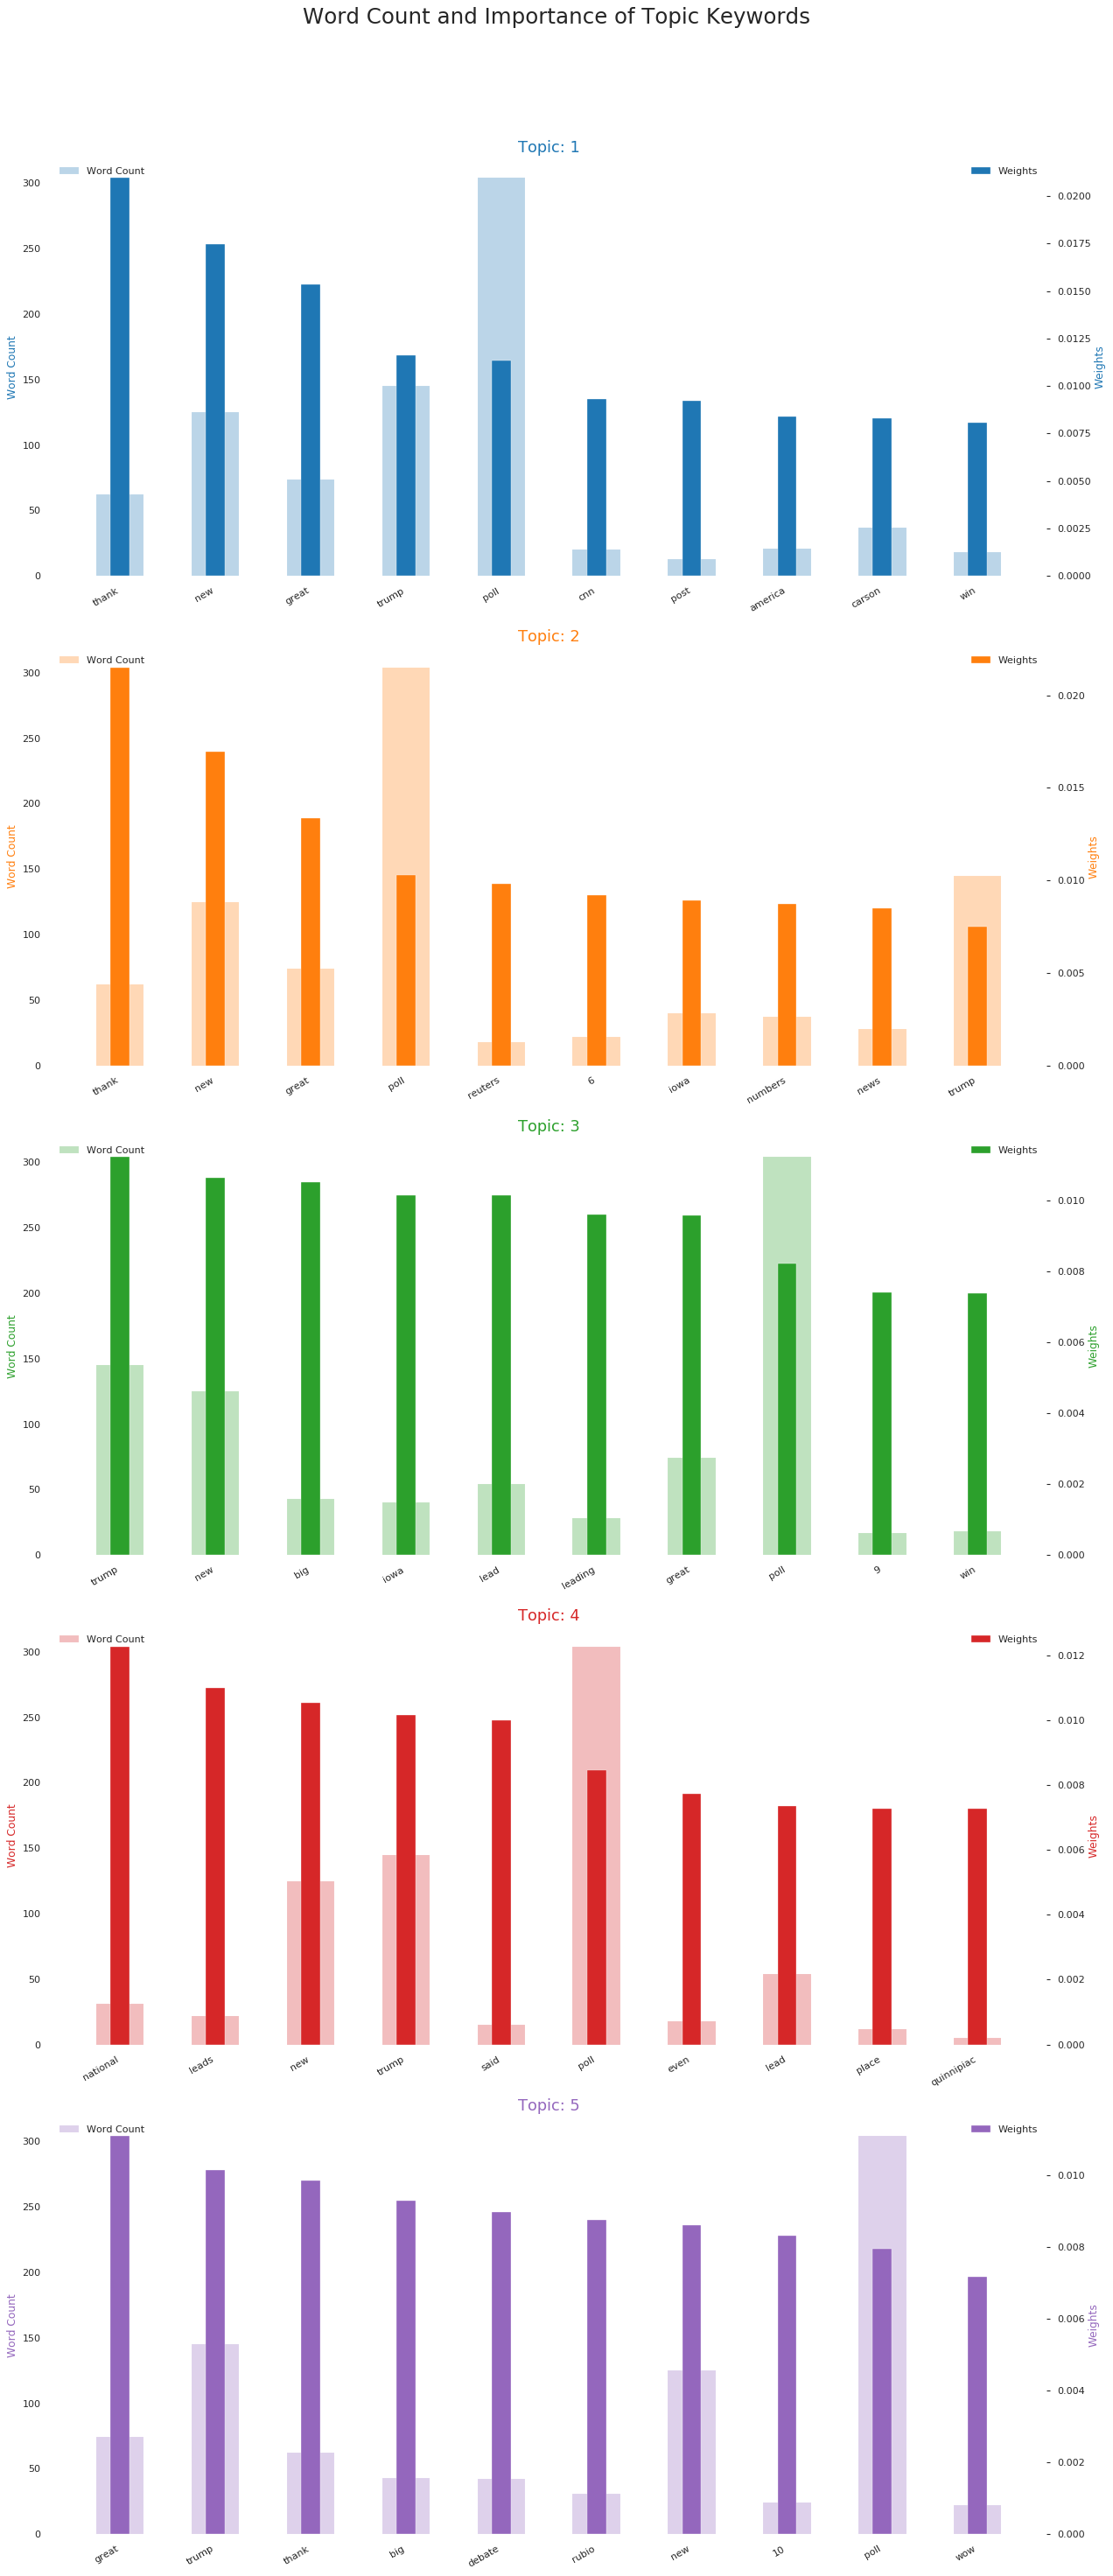

In [25]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(16, 35), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height='word_count', data=data.loc[data.topic_id == i, :], color=cols[i], width=.5, alpha=.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height='importance', data=data.loc[data.topic_id == i, :], color=cols[i], width=.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylabel('Weights', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(data.loc[data.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

#### What are the most discussed topics in the tweets?

In [26]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics, topic_percentages = list(), list()
    for i, corp in enumerate(corpus_sel):
        topic_id_percentages = lda[corp]
        dominant_topic = sorted(topic_id_percentages, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_id_percentages)
    return dominant_topics, topic_percentages

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)

In [27]:
# Distribution of dominant topics in each document
df_2 = pd.DataFrame(dominant_topics, columns=['document_id', 'dominant_topic'])
dominant_topic_in_each_document = df_2.groupby('dominant_topic').size()
df_dominant_topic_in_each_document = dominant_topic_in_each_document.to_frame(name='count').reset_index()

In [28]:
# Total topic distribution by actual weight
topic_weightage_by_document = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_document.sum().to_frame(name='count').reset_index()

In [29]:
# Top 3 keywords for each topic
topic_top_3_words =  [(i, topic) for i, topics in lda.show_topics(formatted=False) for j, (topic, wt) in enumerate(topics) if j < 3]
df_top_3_words_stacked = pd.DataFrame(topic_top_3_words, columns=['topic_id', 'words'])
df_top_3_words = df_top_3_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_3_words.reset_index(level=0, inplace=True)

We will now make two plots:

>1. the number of documents for each topic by assigning the document to the topic that has the most weight in that document.
>2. the number of documents for each topic by summing up the actual weight contribution of each topic to respective documents.

Text(0.5, 1.0, 'Number of Documents by Topic Weightage')

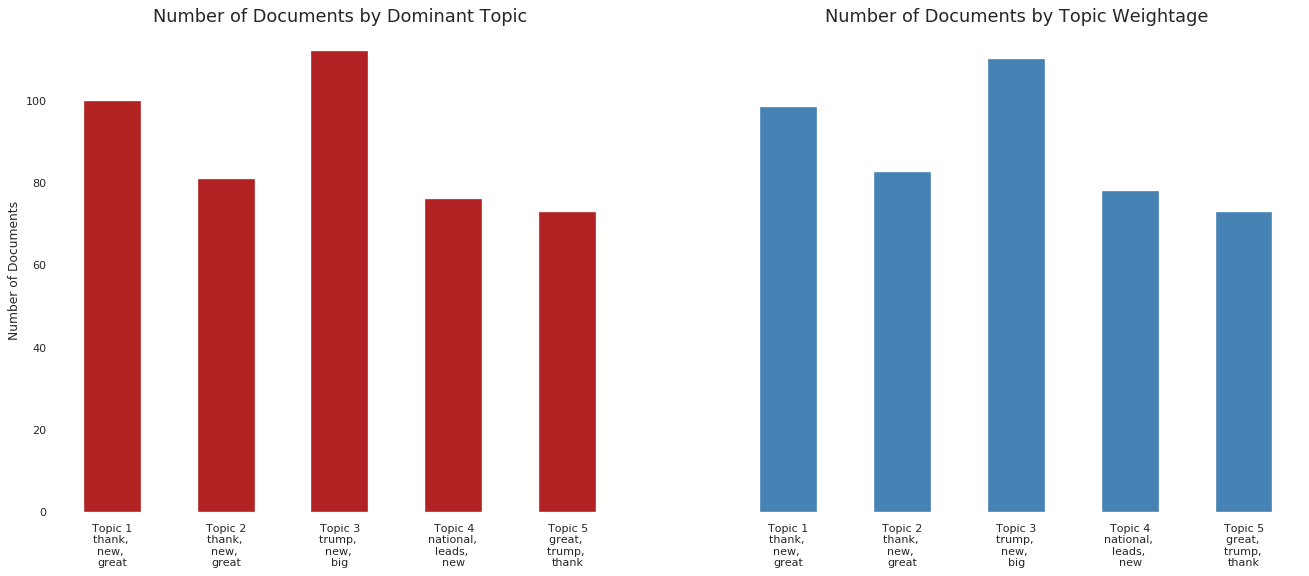

In [30]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)

# Topic distribution by dominant topics
ax1.bar(x='dominant_topic', height='count', data=df_dominant_topic_in_each_document, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_document.dominant_topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1) + '\n' + df_top_3_words.loc[df_top_3_words.topic_id == x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=16))
ax1.set_ylabel('Number of Documents')

# Topic distribution by topic weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=16))

#### Polarity and subjectivity of sentiments

In [31]:
def append_cleaned_text(texts, df, column_name):
    '''Added cleaned text column to dataframe.'''
    cleaned_text = list()
    for i in range(len(texts)):
        if len(texts[i]) != 0:
            cleaned_text.append(' '.join(i for i in texts[i]))
        else:
            cleaned_text.append(' ')
    df[column_name] = cleaned_text

append_cleaned_text(no_emojis_refined_text_corpus, df, 'cleaned_text')

In [32]:
# Create polarity and subjectivity columns
def polarity_and_subjectivity(df, column):
    '''Creates the polarity and subjectivity columns.'''
    polarity, subjectivity = list(), list()
    for tweet in df[column]:
        blob = TextBlob(tweet)
        polarity.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    df['polarity'] = polarity
    df['subjectivity'] = subjectivity

polarity_and_subjectivity(df=df, column='cleaned_text')

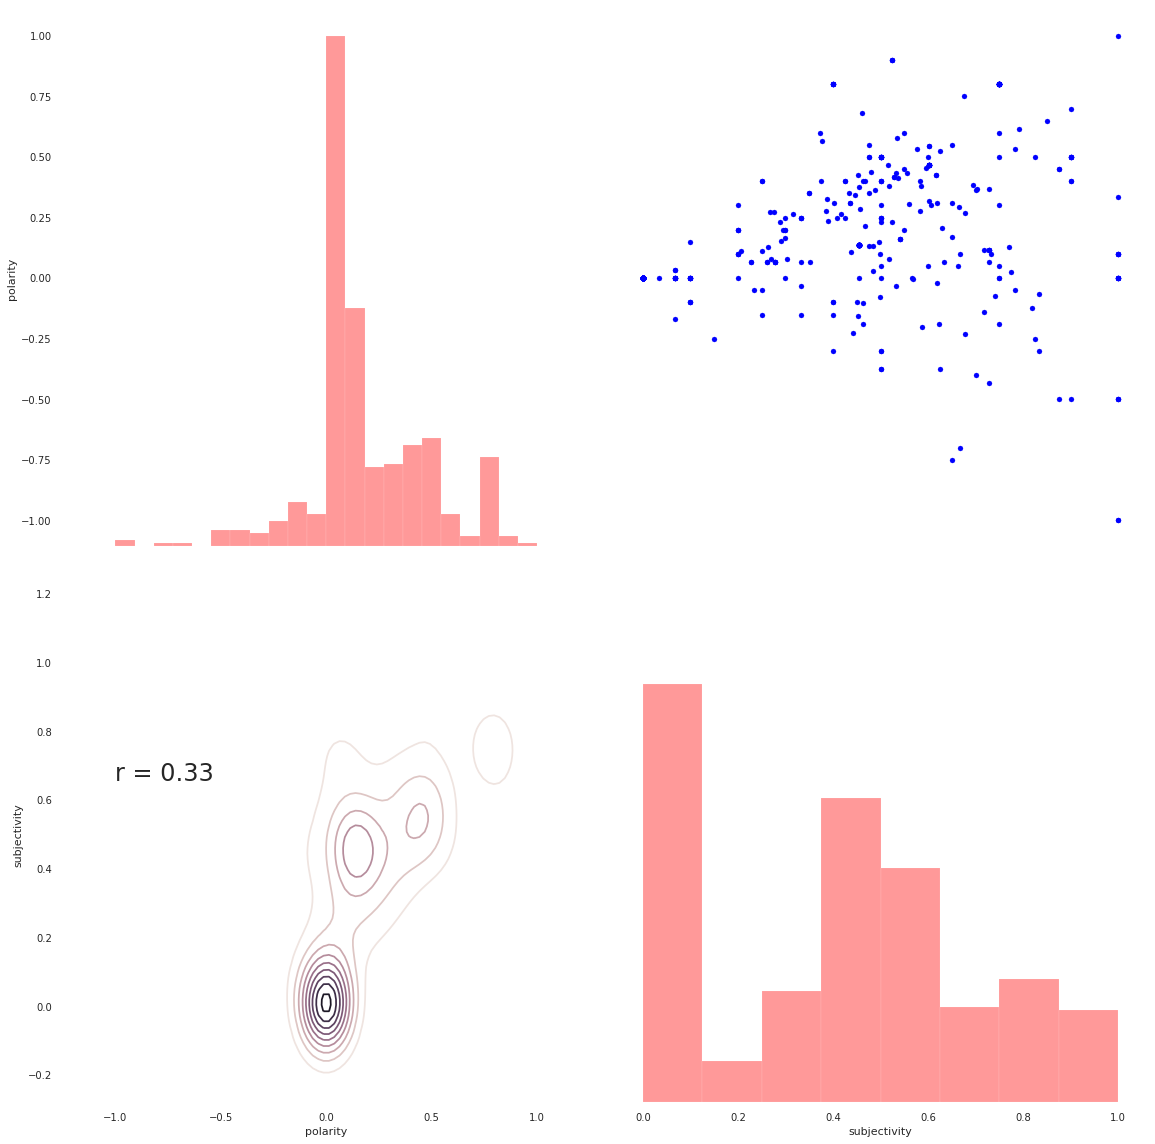

In [33]:
# Correlations
def correlations(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6),
                xycoords=ax.transAxes,
                size=24)

cmap = sns.cubehelix_palette(light=1, dark=.01, hue=.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pairgrid setup
g = sns.PairGrid(df.drop('id', axis=1), height=8)
# Scatterplot on upper triangle
g.map_upper(plt.scatter, s=25, color='blue')
# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color='red')
# Densityplot and correlation coefficients on lower triangle
g.map_lower(sns.kdeplot, cmap=cmap)
g.map_lower(correlations)

(None, None)

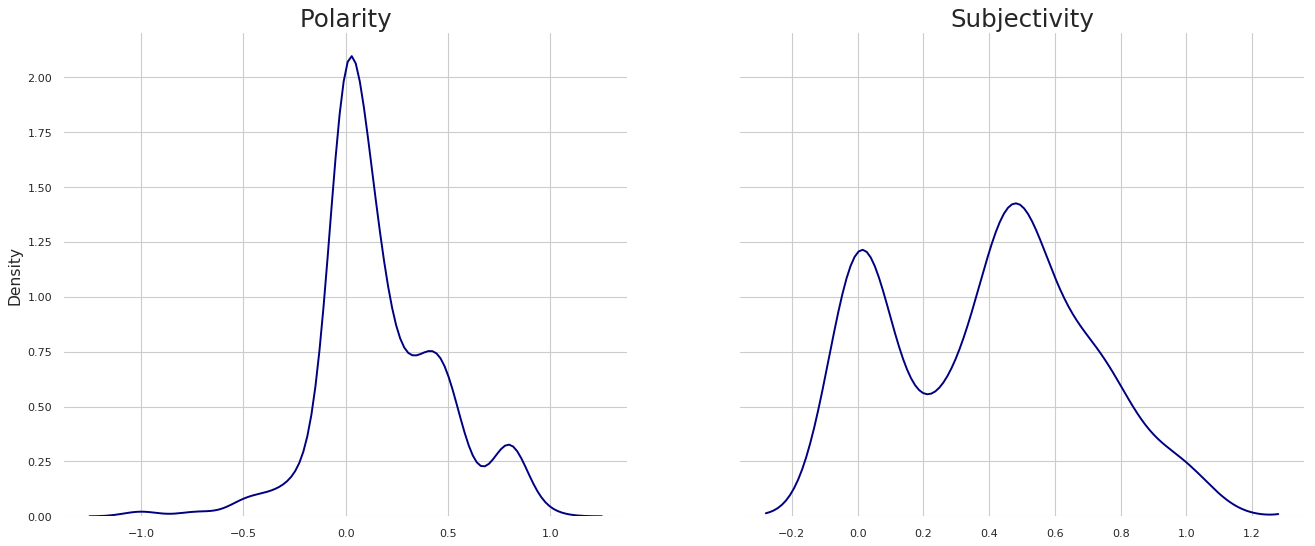

In [34]:
# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(df['polarity'], ax=ax1, color='navy', hist=False)
sns.distplot(df['subjectivity'], ax=ax2, color='navy', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Polarity and subjectivity

(None, None)

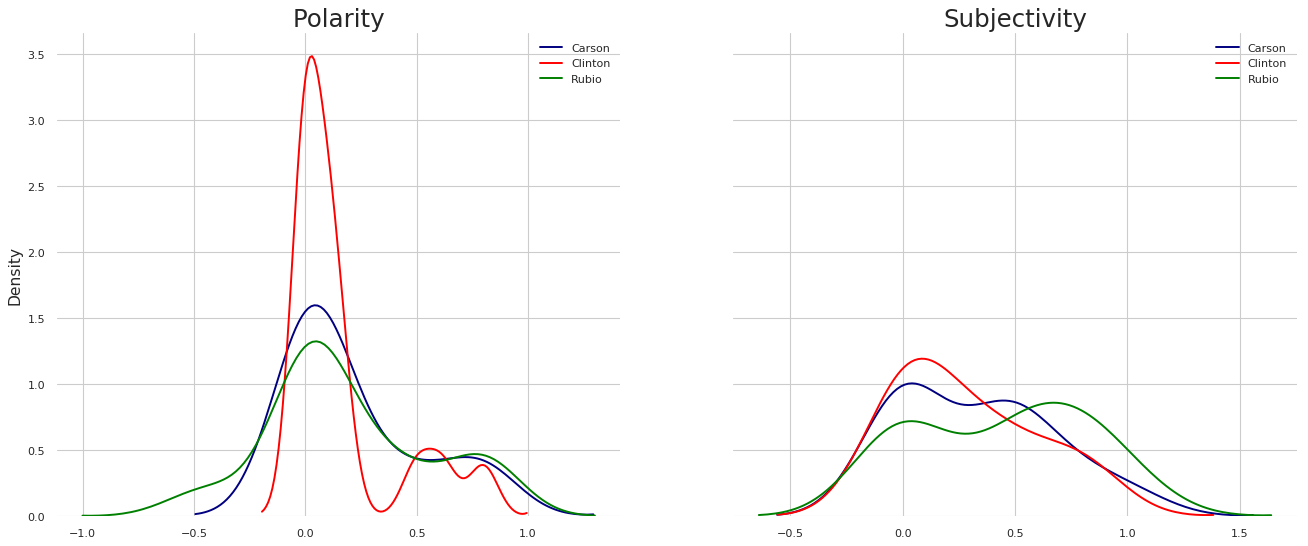

In [35]:
# Comparing subjectivity and polarity between candidates
carson = df.loc[df['text'].str.contains('Carson')]
clinton = df.loc[df['text'].str.contains('Clinton')]
rubio = df.loc[df['text'].str.contains('Rubio')]

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=80, sharey=True)
sns.distplot(carson['polarity'], label='Carson', ax=ax1, color='navy', hist=False)
sns.distplot(clinton['polarity'], label='Clinton', ax=ax1, color='red', hist=False)
sns.distplot(rubio['polarity'], label='Rubio', ax=ax1, color='green', hist=False)
sns.distplot(carson['subjectivity'], label='Carson', ax=ax2, color='navy', hist=False)
sns.distplot(clinton['subjectivity'], label='Clinton', ax=ax2, color='red', hist=False)
sns.distplot(rubio['subjectivity'], label='Rubio', ax=ax2, color='green', hist=False)
ax1.set_title('Polarity', fontsize=22), ax2.set_title('Subjectivity', fontsize=22)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_xlabel(''), ax2.set_xlabel('')
ax1.grid(), ax2.grid()

#### Comparison: Time series of polarity and subjectivity

In [36]:
# Creating time series objects
# Polarity
carson_polarity = ts.create_series(carson, 'created_at', 'polarity')
clinton_polarity = ts.create_series(clinton, 'created_at', 'polarity')
rubio_polarity = ts.create_series(rubio, 'created_at', 'polarity')

# Subjectivity
carson_subjectivity = ts.create_series(carson, 'created_at', 'subjectivity')
clinton_subjectivity = ts.create_series(clinton, 'created_at', 'subjectivity')
rubio_subjectivity = ts.create_series(rubio, 'created_at', 'subjectivity')

In [37]:
def smooth(x,window_len=11,window='hanning'):
    '''smooth the data using a window with requested size.
    
    NB: Taken from scipy cookbook.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    '''

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    return np.convolve(w/w.sum(), s, mode='valid')

(None, None)

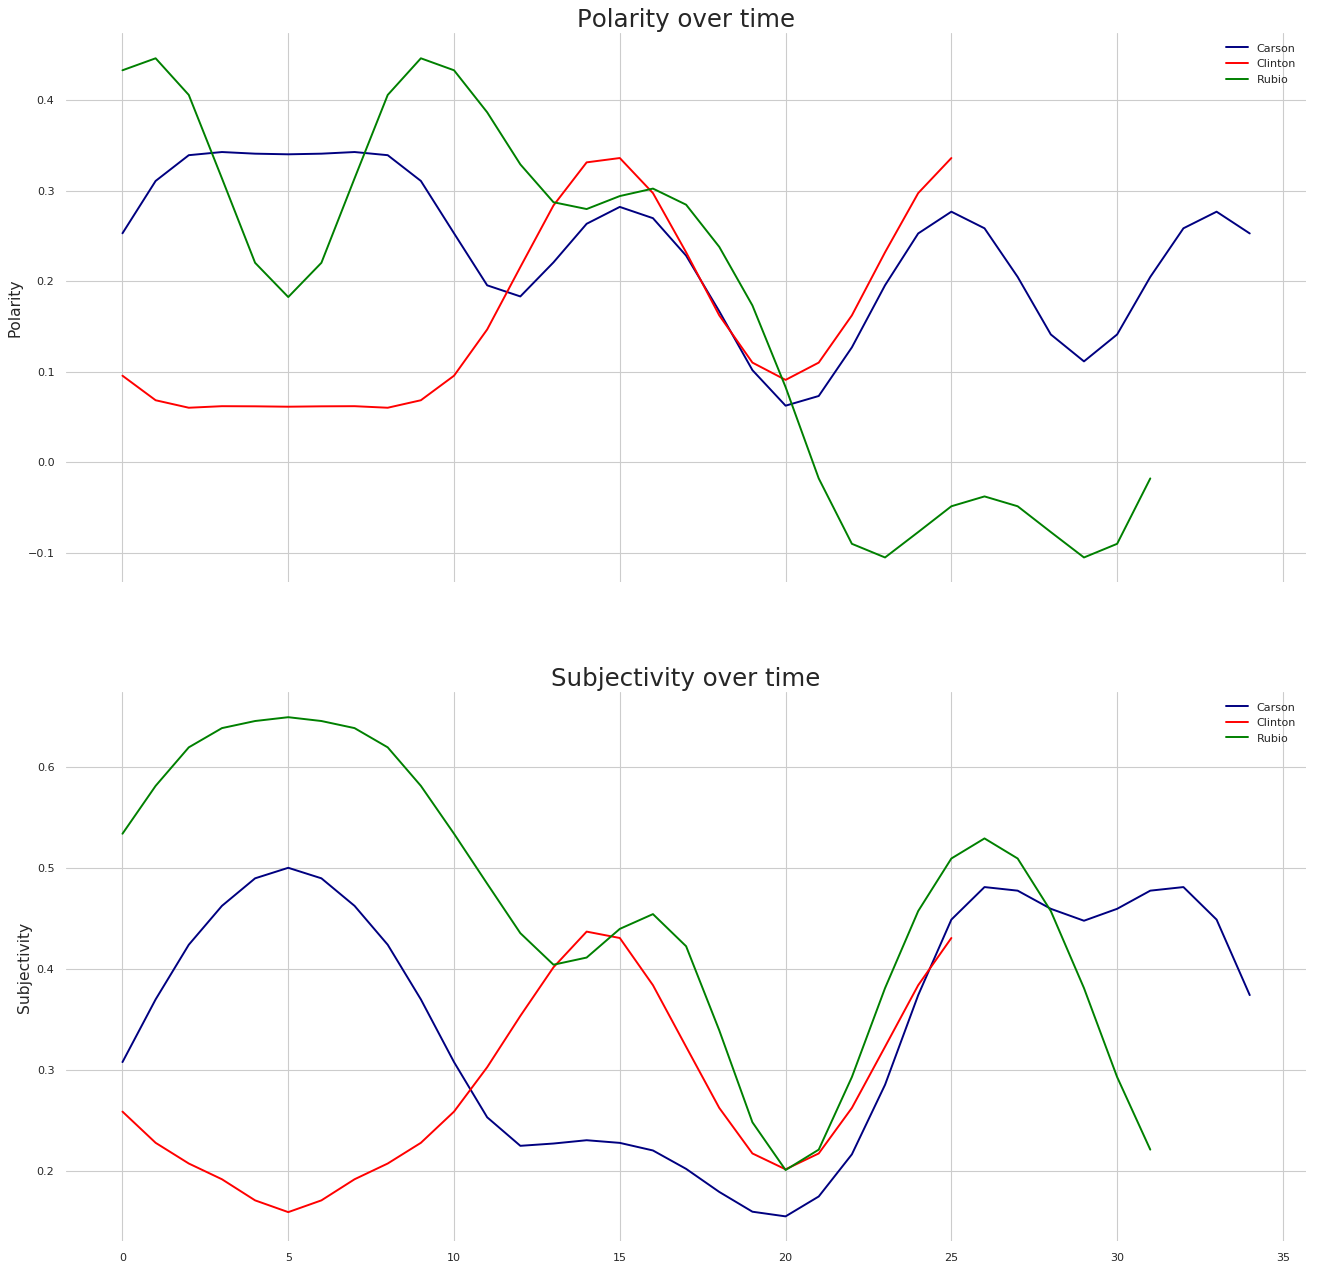

In [38]:
# Plotting polarity
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), dpi=80, sharex=True)
sns.lineplot(data=smooth(carson_polarity), label='Carson', color='navy', ax=ax1)
sns.lineplot(data=smooth(clinton_polarity), label='Clinton', color='red', ax=ax1)
sns.lineplot(data=smooth(rubio_polarity), label='Rubio', color='green', ax=ax1)
sns.lineplot(data=smooth(carson_subjectivity), label='Carson', color='navy', ax=ax2)
sns.lineplot(data=smooth(clinton_subjectivity), label='Clinton', color='red', ax=ax2)
sns.lineplot(data=smooth(rubio_subjectivity), label='Rubio', color='green', ax=ax2)
ax1.set_title('Polarity over time', fontsize=22)
ax2.set_title('Subjectivity over time', fontsize=22)
ax1.set_ylabel('Polarity', fontsize=14)
ax2.set_ylabel('Subjectivity', fontsize=14)
ax1.legend(), ax2.legend()
ax1.grid(), ax2.grid()